In [3]:
import sys, subprocess
try:
    import pandas as pd
    import numpy as np
    from sklearn.neighbors import NeighborhoodComponentsAnalysis
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import seaborn as sns
except Exception:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-learn', 'pandas', 'matplotlib', 'seaborn'])
    import pandas as pd
    import numpy as np
    from sklearn.neighbors import NeighborhoodComponentsAnalysis
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import seaborn as sns

sns.set(style='whitegrid')
%matplotlib inline

In [4]:
# Load features CSV
csv_path = '../data/features_glcm_lbp_hsv.csv'
df = pd.read_csv(csv_path)
print('shape:', df.shape)
df.head()

shape: (3277, 63)


,filename,glcm_contrast_mean,glcm_contrast_std,glcm_dissimilarity_mean,glcm_dissimilarity_std,glcm_homogeneity_mean,glcm_homogeneity_std,glcm_energy_mean,glcm_energy_std,glcm_correlation_mean,...,s_14,s_15,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7
0,Oppo_A_H1f1_Kanan_cutout.png,0.516554,0.268627,0.244475,0.086715,0.898409,0.030346,0.522735,0.013680,0.961883,...,0.009491,0.006078,0.000067,0.000604,0.004161,0.022151,0.037628,0.024558,0.226227,0.017938
1,Oppo_A_H1f1_Kiri_cutout.png,0.278968,0.134639,0.165547,0.054764,0.927073,0.020700,0.649369,0.006279,0.974637,...,0.005670,0.001174,0.000127,0.001106,0.004824,0.015162,0.024534,0.029481,0.247673,0.010426
2,Oppo_A_H1f2_Kanan_cutout.png,0.521560,0.310321,0.196648,0.078032,0.923426,0.025398,0.430942,0.013660,0.944804,...,0.001184,0.000294,0.000373,0.002165,0.003543,0.009580,0.021927,0.065501,0.209443,0.020802
3,Oppo_A_H1f2_Kiri_cutout.png,0.471625,0.275858,0.184614,0.075377,0.926882,0.025725,0.438172,0.014524,0.949897,...,0.001129,0.000239,0.000587,0.001966,0.003307,0.008329,0.024527,0.051591,0.217470,0.025556
4,Oppo_B_H1f1_Kanan_cutout.png,0.329307,0.155926,0.185395,0.058224,0.918389,0.022130,0.599386,0.010853,0.976097,...,0.007974,0.004037,0.000191,0.001194,0.005349,0.017930,0.037181,0.015287,0.254149,0.002052


In [5]:
# Extract label from filename: the H-number (e.g. H1, H2...), case-insensitive
# capture lowercase 'h' too and normalize to uppercase like 'H10'
df['label'] = df['filename'].str.extract(r'(?i)(h\d+)')[0].str.upper()
df['label'] = df['label'].fillna('UNKNOWN')
# numeric codes for supervised learning
df['label_code'] = pd.factorize(df['label'])[0]
print(df['label'].value_counts())
df[['filename','label','label_code']].head()

label
H4     344
H2     344
H7     344
H6     344
H5     343
H1     343
H3     343
H8     328
H9     286
H10    258
Name: count, dtype: int64


,filename,label,label_code
0,Oppo_A_H1f1_Kanan_cutout.png,H1,0
1,Oppo_A_H1f1_Kiri_cutout.png,H1,0
2,Oppo_A_H1f2_Kanan_cutout.png,H1,0
3,Oppo_A_H1f2_Kiri_cutout.png,H1,0
4,Oppo_B_H1f1_Kanan_cutout.png,H1,0


In [6]:
# Prepare feature matrix X and labels y (use all columns except filename/label columns)
exclude = {'filename','label','label_code'}
feature_cols = [c for c in df.columns if c not in exclude]
X = df[feature_cols].values
y = df['label_code'].values
print('features:', len(feature_cols))

features: 62


In [7]:
# Standardize features before NCA
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [9]:
# Fit NCA to 9 components and transform
n_components = 9
nca = NeighborhoodComponentsAnalysis(n_components=n_components, random_state=42)
nca.fit(Xs, y)
X_nca = nca.transform(Xs)
# Build a small dataframe with transformed coords and labels
df_nca = df[['filename','label']].copy()
for i in range(n_components):
    df_nca[f'nca{i}'] = X_nca[:, i]
out_csv = '../data/features_nca_9.csv'
df_nca.to_csv(out_csv, index=False)
print('Saved transformed features to', out_csv)
df_nca.head()

KeyboardInterrupt: 

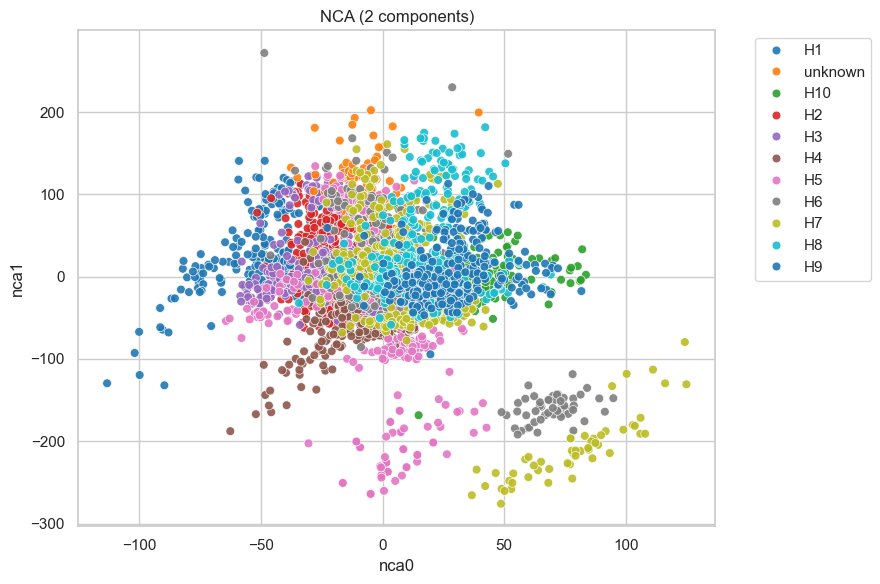

In [ ]:
# Quick 2D scatter plot of NCA result
plt.figure(figsize=(9,6))
ax = sns.scatterplot(x='nca0', y='nca1', hue='label', data=df_nca, palette='tab10', s=40, alpha=0.9)
ax.set_title('NCA (2 components)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Optionally compute a higher-dim NCA (e.g., 10 components) and save
try:
    n_components2 = 10
    nca2 = NeighborhoodComponentsAnalysis(n_components=n_components2, random_state=42)
    nca2.fit(Xs, y)
    X_nca2 = nca2.transform(Xs)
    cols = {f'nca10_{i}': X_nca2[:, i] for i in range(n_components2)}
    df_nca2 = df[['filename','label']].copy()
    for k,v in cols.items():
        df_nca2[k] = v
    out_csv2 = 'features_nca_10.csv'
    df_nca2.to_csv(out_csv2, index=False)
    print('Saved', out_csv2)
except Exception as e:
    print('Skipping 10-dim NCA:', e)

Saved features_nca_10.csv
